<h3>ADCIRC Region 3 Simulation Database</h3>

The ADCIRC Region 3 Simulation database size is currently 22 TB. It is a <a href="https://www.postgresql.org/">PostgreSQL</a> database, that uses <a href="https://www.timescale.com/">TimescaleDB</a>, and <a href="https://postgis.net/">PostGIS</a> extensions. TimescaleDB enables storing large amounts of data in PostgreSQL, by using hypertables, which are comprised of many interlinked sub-tables called chunks. Chunks are created by partitioning the hypertable's data into one or multiple dimensions: All hypertables are partitioned by a time interval, and can additionally be partitioned by a key such as device ID, location, user id, etc. 

Each storm from the Region 3 Simulation data is stored in it's own table, which are partitioned into chunks by 2 hour time intervales. The geometry data are stored in a separate PostGIS table that can be linked to the storm tables in a query.

We serve the data using <a href="https://github.com/CrunchyData/pg_tileserv">pg_tileserv</a>, which is a vector tile data server.

In [1]:
# To download, read and display the data, first import these Python module
import requests, subprocess
from ast import literal_eval
from vt2geojson.tools import vt_bytes_to_geojson
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [2]:
# This is a python function that retrieves the data from the database server. 
# It's inputs are storm table name, timestamp, and region of interest (roi) file
# which containes the bounding box coordinates. The vector tiles are downloaded 
# and stiched together.
def getData(stormtable, timestamp, roi):
    # Geodex calculates the tiles in the bounding box roi
    std_result = subprocess.run(['geodex', roi, str(13), '--output-format', '({z}, {x}, {y})'], 
                                stdout=subprocess.PIPE)
    tile_inds_string = std_result.stdout.decode('utf-8').split('\n')
    tile_inds_tuple = [literal_eval(ti) for ti in tile_inds_string if len(ti) > 0]

    gdfall = gpd.GeoDataFrame()

    for tile in tile_inds_tuple:
        # region3_sim_storms_bufopt is a PLSQL function that tackes zoom level, x and y 
        # tile coordinates, buffer size, storm table, and timestamp as input. The function
        # links the storm table with the geometry table and outputs a vector tile.
        tileURL = "http://localhost:7800/public.region3_sim_storms_bufopt/"+ \
                  str(tile[0])+"/"+str(tile[1])+"/"+str(tile[2])+".pbf?buffer=0&stormtable="+ \
                  stormtable+"&timestep="+timestamp+"&properties=node,zeta,bathymetry"
        r = requests.get(tileURL)

        assert r.status_code == 200, r.content
        vt_content = r.content

        features = vt_bytes_to_geojson(vt_content, tile[1], tile[2], tile[0])
        gdf = gpd.GeoDataFrame.from_features(features)
        gdfall = pd.concat([gdfall,gdf])

    gdfall = gdfall.sort_values(by=['node'], ascending=True)
    gdfall = gdfall.reset_index(drop=True)
    duplicateRowGDF = gdfall[gdfall.duplicated(['node'])]
    
    if len(duplicateRowGDF) > 0:
        print(len(duplicateRowGDF))
 
    return(gdfall)

In [3]:
# When you run the getData funciton with the required input, it outputs a geopandas dataframe.
stormtable = 'var_dp3r3b1c1h1l1_fort63'
timestep = '2000-09-03T20:30:00'

# The roi is ov central chesapeake Bay
roi = '/home/jmcmanus/Work/Surge/development/jupyterInteractive/reg3simInteractive/roi.geojson'
gdf = getData(stormtable, timestep, roi)
gdf.head()

,geometry,node,bathymetry,zeta
0,POINT (-76.11368 38.82117),153814,-4.2484112,NaN
1,POINT (-76.11448 38.82387),153815,-4.837077,NaN
2,POINT (-76.11329 38.82603),153816,-4.9151185,NaN
3,POINT (-76.11369 38.78163),156471,-3.9950436,NaN
4,POINT (-76.11347 38.78365),156472,-4.682347,NaN


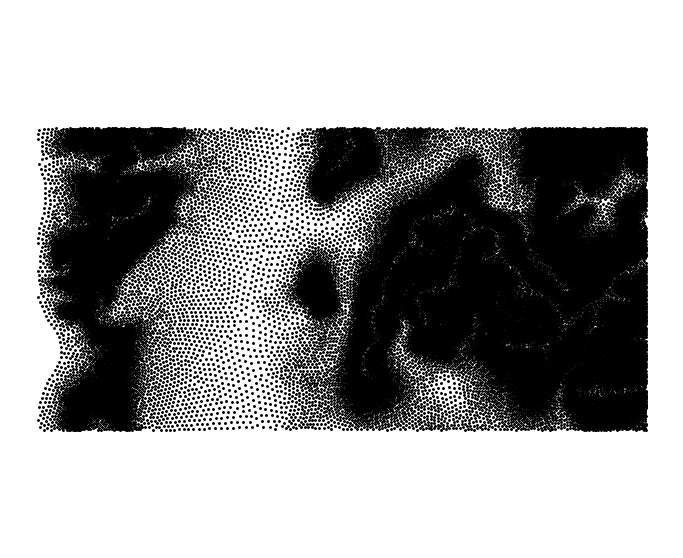

In [4]:
# The display the points using MatPlotLib
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, markersize=3.5, color='black')
ax.axis('off')
plt.axis('equal')
plt.show()

In [5]:
# One way of displaying the data is to regrid it and display it as an image
# This can be done by first defining the region, and then createing a basemap
lllon = min(gdf.geometry.bounds.minx)
lllat = min(gdf.geometry.bounds.miny)
urlon = max(gdf.geometry.bounds.maxx)
urlat = max(gdf.geometry.bounds.maxy)

# set up basemap chose projection!
m = Basemap(projection = 'merc', resolution='c',llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat)

In [6]:
# Then pull out pull out the variables
lon = gdf.geometry.x.to_numpy()
lat = gdf.geometry.y.to_numpy()

# The Region 3 Simulation depth data is depth below geoid, which means the land values are negative.
# So here we rescale the data so the the land values are positive
bathymetry = gdf.bathymetry.to_numpy().astype(np.float)
minusones = np.ones(54448,) - 2
bathymetry = bathymetry * minusones

# Zeta is water surface elevation above geoid
zeta = gdf.zeta.to_numpy().astype(np.float)

# transform coordinates to map projection m
m_lon, m_lat = m(*(lon, lat))

In [7]:
# generate grid data
numcols, numrows = 240, 240
xi = np.linspace(m_lon.min(), m_lon.max(), numcols)
yi = np.linspace(m_lat.min(), m_lat.max(), numrows)
xi, yi = np.meshgrid(xi, yi)

# interpolate the zeta data
zi = griddata((m_lon, m_lat), zeta, (xi, yi), method='linear', fill_value=np.nan, rescale=False)

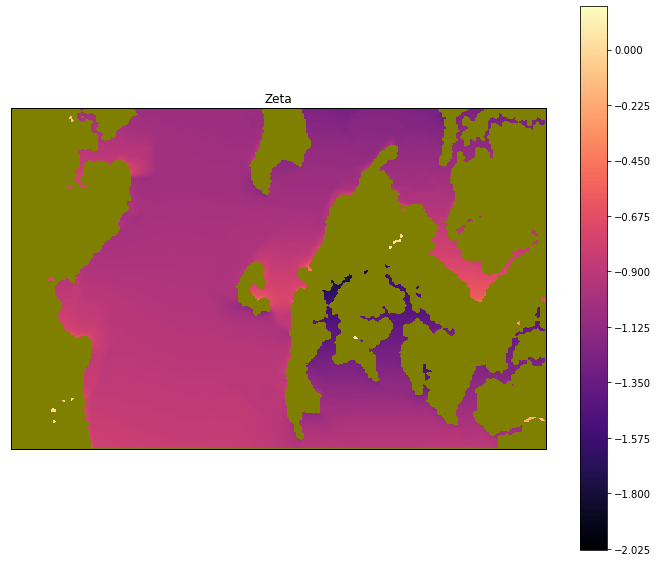

In [8]:
# Plot the zeta data
fig, ax = plt.subplots(figsize=(12, 10))

# draw map details
m.drawmapboundary(fill_color = 'olive', zorder = 1)

# Plot interpolated bathymetry
m.contourf(xi, yi, zi, 500, cmap='magma', zorder = 2)

cbar = plt.colorbar()
plt.title('Zeta')
plt.show()

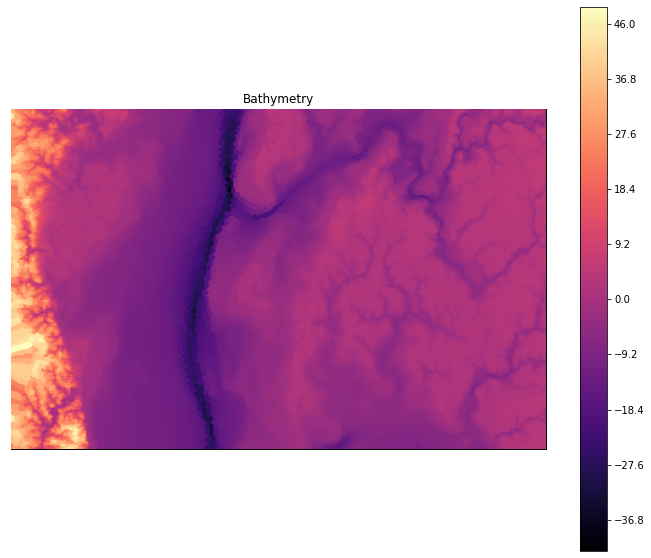

In [9]:
# interpolate the bathymetry data
zi = griddata((m_lon,m_lat),bathymetry,(xi,yi),method='nearest',fill_value=np.nan)

# Plot the bathymetry data
fig, ax = plt.subplots(figsize=(12, 10))

# draw map details
m.drawmapboundary(fill_color = 'olive', zorder = 1)

# Plot interpolated bathymetry
m.contourf(xi, yi, zi, 500, cmap='magma', zorder = 2)

cbar = plt.colorbar()
plt.title('Bathymetry')
plt.show()

In [10]:
# When you run the getData funciton with the required input, it outputs a geopandas dataframe.
stormtable = 'var_dp3r3b1c1h1l1_swan63'
timestep = '2000-09-03T20:30:00'

# The roi is ov central chesapeake Bay
roi = '/home/jmcmanus/Work/Surge/development/jupyterInteractive/reg3simInteractive/roi.geojson'
gdf = getData(stormtable, timestep, roi)
gdf.head()

,geometry,node,bathymetry,hs,tps,dir
0,POINT (-76.11368 38.82117),153814,-4.2484112,NaN,NaN,NaN
1,POINT (-76.11448 38.82387),153815,-4.837077,NaN,NaN,NaN
2,POINT (-76.11329 38.82603),153816,-4.9151185,NaN,NaN,NaN
3,POINT (-76.11369 38.78163),156471,-3.9950436,NaN,NaN,NaN
4,POINT (-76.11347 38.78365),156472,-4.682347,NaN,NaN,NaN


In [11]:
hs = gdf.hs.to_numpy().astype(np.float)
# interpolate the hs data
zi = griddata((m_lon, m_lat), hs, (xi, yi), method='linear', fill_value=np.nan, rescale=False)

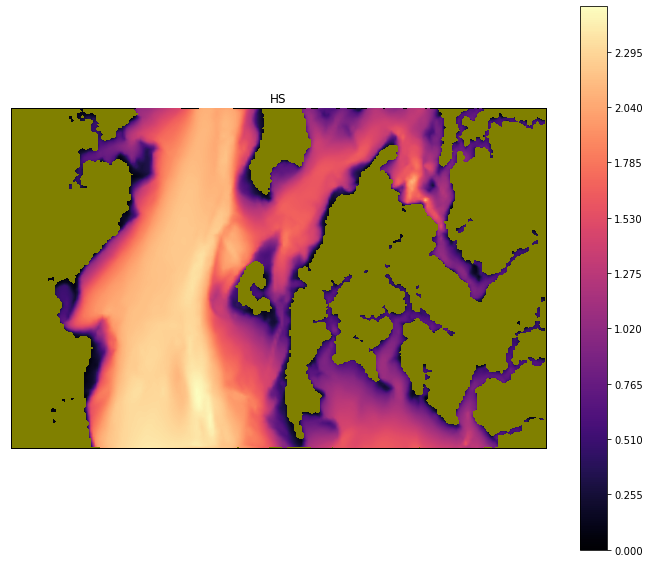

In [12]:
# Plot the zeta data
fig, ax = plt.subplots(figsize=(12, 10))

# draw map details
m.drawmapboundary(fill_color = 'olive', zorder = 1)

# Plot interpolated bathymetry
m.contourf(xi, yi, zi, 500, cmap='magma', zorder = 2)

cbar = plt.colorbar()
plt.title('HS')
plt.show()